In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json, sys

from azure.ai.ml import command
from azure.ai.ml.entities import Data, AmlCompute, Environment
from azure.ai.ml.entities import AzureBlobDatastore
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes, InputOutputModes

from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)

In [2]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

In [3]:
with open("./config.json") as f:
    config = json.load(f)
print(config)

{'subscription_id': '1fad602f-d06f-46af-8f70-78a2c2c53b24', 'resource_group': 'MLGroup', 'workspace_name': 'shivamlservice'}


In [4]:
workspace_name = config["workspace_name"]
resource_group = config["resource_group"]
subscription_id = config["subscription_id"]


In [5]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace_name,
)
ml_client

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x7f23e3162380>,
         subscription_id=1fad602f-d06f-46af-8f70-78a2c2c53b24,
         resource_group_name=MLGroup,
         workspace_name=shivamlservice)

In [6]:
import os

dependencies_dir = "./environment_setup"
os.makedirs(dependencies_dir, exist_ok=True)

In [7]:
%%writefile {dependencies_dir}/conda.yml
name: spam-mlops-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pip:  
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0
    - numpy
    - pandas
    - matplotlib
   

Overwriting ./environment_setup/conda.yml


In [8]:
"""Load labeled spam dataset."""

# Path where csv files are located
base_path = "./data/csv_data"

# List of csv files with full path
csv_files = [os.path.join(base_path, csv) for csv in os.listdir(base_path)]

dfs = []
# List of dataframes for each file
for filename in csv_files:
    if filename.endswith('.csv'):
        dfs.append(pd.read_csv(filename))
        
# Concatenate all data into one DataFrame
df = pd.concat(dfs)

# Rename columns
df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

# Set a seed for the order of rows
df = df.sample(frac=1, random_state=824)

df = df.reset_index()

df.tail()


,index,COMMENT_ID,AUTHOR,DATE,text,label
1133,69,z12qvnw51y31ulrx304cjbkq1yzqzdkiytg0k,jessica durham,2014-09-09T06:10:07,Please help me give my son a grave. http://ww...,1
1134,206,z13wt1vrismyzpiij04cj5vz4nzlyj4yfzo0k,Alexander Mcdonald,2014-10-13T09:19:13,"Anyone Who LOVEs music , please go check out m...",1
1135,127,z13rfjuxmtm3vd2eb23qi1brgq3ic5nxv04,Marshmallow Kingdom,2015-05-20T12:40:57.549000,THUMBS UP FOR ROBO GUY BABY﻿,0
1136,237,z13iwppp5kf4gnyxn04cjns5kzn4xd0qdwk0k,juanmanuel cespedes,2014-11-07T22:59:13,i hate this music. fucking singer and every ko...,0
1137,133,z12de5li5lzwcbblp23gc11zmli4t5r10,Dicky Tricahyadi,2015-05-20T05:49:45.161000,LMFAO IS THE BEST﻿,0


Value counts for each class:

1    586
0    552
Name: label, dtype: int64



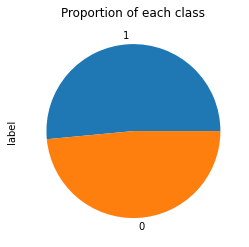

In [9]:
# Print actual value count
print(f"Value counts for each class:\n\n{df.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

In [10]:
# Drop unused columns
df = df.drop(['index', 'COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)
df.shape

(1138, 2)

In [11]:
try:
    os.makedirs('./data/training_data', exist_ok=True)
    df.to_csv('./data/training_data/spam.csv', index=False, header=True)
    print('spam.csv training data created')
except:
    print("directory already exists")


spam.csv training data created


In [40]:
from azure.ai.ml.entities import Data

my_path = './data/training_data/spam.csv'

my_data = Data(
    path=my_path,
    type=AssetTypes.URI_FILE,
    description="youtube data for spam classification mlops example",
    name="spam_class"
)

ml_client.data.create_or_update(my_data)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'spam_class', 'description': 'youtube data for spam classification mlops example', 'tags': {}, 'properties': {}, 'id': '/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourceGroups/MLGroup/providers/Microsoft.MachineLearningServices/workspaces/shivamlservice/data/spam_class/versions/4', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/shiva-standard-compute/code/Users/shchitt/Spam_Classification_MLOps_V2', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f36d3a81330>, 'serialize': <msrest.serialization.Serializer object at 0x7f36d3a81210>, 'version': '4', 'latest_version': None, 'path': 'azureml://subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourcegroups/MLGroup/workspaces/shivamlservice/datastores/workspaceblobstore/paths/LocalUploa

In [12]:
# Get data from AML Data Assets
spam_dataset = ml_client.data.get(name="spam_class", label="latest")
spam_dataset

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'spam_class', 'description': 'youtube data for spam classification mlops example', 'tags': {}, 'properties': {}, 'id': '/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourceGroups/MLGroup/providers/Microsoft.MachineLearningServices/workspaces/shivamlservice/data/spam_class/versions/5', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/shiva-standard-compute/code/Users/shchitt/Spam_Classification_MLOps_V2', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f23b55e9180>, 'serialize': <msrest.serialization.Serializer object at 0x7f23c5d67460>, 'version': '5', 'latest_version': None, 'path': 'azureml://subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourcegroups/MLGroup/workspaces/shivamlservice/datastores/workspaceblobstore/paths/LocalUploa

In [14]:
pip install -U azureml-fsspec mltable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: mltable
    Found existing installation: mltable 1.0.0
    Uninstalling mltable-1.0.0:
      Successfully uninstalled mltable-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [13]:
df = pd.read_csv(spam_dataset.path)
df.head()

,text,label
0,go here to check the views :3﻿,0
1,Follow me watch my videos :) Follow me watch m...,1
2,go check out our video﻿,1
3,I love it﻿,0
4,The best song ever!﻿,0


In [14]:
import re 
df['text'] = df['text'].apply(lambda text: re.sub('[^A-Za-z]+', ' ', text.lower()))
df.head()

,text,label
0,go here to check the views,0
1,follow me watch my videos follow me watch my v...,1
2,go check out our video,1
3,i love it,0
4,the best song ever,0


In [15]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_DS3_V2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

    print(f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}")

You already have a cluster named cpu-cluster, we'll reuse it as is.


In [16]:
import os

dependencies_dir = "./environment_setup"
os.makedirs(dependencies_dir, exist_ok=True)

In [17]:
%%writefile {dependencies_dir}/conda.yml
name: spam-mlops-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pip:  
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0
    - numpy
    - pandas
    - matplotlib

Overwriting ./environment_setup/conda.yml


In [18]:
from azure.ai.ml.entities import Environment

custom_env_name = "spam-mlops-env"

try:
    # let's see if the environment already exists    
    job_env = ml_client.environments.get(name=custom_env_name, version=3)
    print(f"You already have the same environment, we'll reuse it as is.")
    #print(job_env)
    
except:
    job_env = Environment(
        name=custom_env_name,
        description="Custom environment for sklearn image classification",
        conda_file=os.path.join(dependencies_dir, "conda.yml"),
        image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
    )
    job_env = ml_client.environments.create_or_update(job_env)

    print(
        f"Environment with name {job_env.name} is registered to workspace, the environment version is {job_env.version}"
    )

You already have the same environment, we'll reuse it as is.


In [19]:
import os

train_src_dir = "./scripts/training"
os.makedirs(train_src_dir, exist_ok=True)

In [45]:
%%writefile {train_src_dir}/main-autolog.py

import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os, json, sys
import joblib
import mlflow
import argparse

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# define functions
def main(args):
           
    # enable auto logging
    mlflow.autolog()

    # read in data
    df = pd.read_csv(args.spam_csv)
    df['text'] = df['text'].apply(lambda text: re.sub('[^A-Za-z]+', ' ', text.lower()))
    
    X = df[['text']]
    y = df[['label']]

    # Use 1/5 of the data for testing later
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=args.test_size, random_state=args.random_state, stratify=y)

    # Print number of comments for each set
    print(f"There are {X_train.shape[0]} comments for training.")
    print(f"There are {X_test.shape[0]} comments for testing")

    clf = make_pipeline(
        #TfidfVectorizer(stop_words=get_stop_words('en')),
        TfidfVectorizer(),
        SVC(kernel='linear', probability=True)
    )

    clf = clf.fit(X=X_train['text'], y=y_train['label'])
    
    # Make predictions for the test set
    y_pred = clf.predict(X_test['text'])

    # Return accuracy score
    true_acc = accuracy_score(y_pred, y_test)
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

    plt.savefig("confusion_matrix.png")

    print('Accuracy: %.3f' % true_acc)

    precision = precision_score(y_test, y_pred)
    print('Precision: %.3f' % precision)

    recall = recall_score(y_test, y_pred)
    print('Recall: %.3f' % recall)

    f1 = f1_score(y_test, y_pred)
    print('f1: %.3f' % f1)

    #### MODEL
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=clf,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )
    
    # Saving the model to a file
    print("Saving the model via MLFlow")
    mlflow.sklearn.save_model(
        sk_model=clf,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )
        
# run script
if __name__ == "__main__":
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--spam-csv", type=str)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    parser.add_argument("--random_state", type=int, default=42)
    parser.add_argument("--test_size", type=float, required=False, default=0.20)

    # parse args
    args = parser.parse_args()
    
    # run main function
    main(args)


Overwriting ./scripts/training/main-autolog.py


In [46]:
model_name = "spam-svm-classifier"

# create the command
job = command(
    code="./scripts/training",  # local path where the code is stored
    command="python main-autolog.py --spam-csv ${{inputs.spam}} --registered_model_name ${{inputs.registered_model_name}}",
    inputs=dict(
        spam=Input(type="uri_file", path=spam_dataset.id),
        registered_model_name=model_name,
    ),
    environment=job_env,
    compute="cpu-cluster",
    display_name="spam-class-mlops-v2",
    experiment_name="exp-spam-class-mlops-v2",
    #description=""
)

In [47]:
# submit the command
returned_job = ml_client.create_or_update(job)
returned_job

Uploading training (0.01 MBs): 100%|██████████| 7388/7388 [00:00<00:00, 191079.28it/s]




Experiment,Name,Type,Status,Details Page
exp-spam-class-mlops-v2,icy_beach_5xq4xxk5m8,command,Starting,Link to Azure Machine Learning studio


In [48]:
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

Monitor your job at https://ml.azure.com/runs/icy_beach_5xq4xxk5m8?wsid=/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourcegroups/MLGroup/workspaces/shivamlservice&tid=16b3c013-d300-468d-ac64-7eda0820b6d3


In [49]:
job_config = {}
job_config["job_id"] = returned_job.id
job_config["job_name"] = returned_job.name
job_config["experiment_name"] = returned_job.experiment_name
with open("./configuration/job_config.json", "w") as outfile:
    json.dump(job_config, outfile)

In [40]:
import mlflow
experiment_name = "exp-spam-class-mlops-v2"
exp = mlflow.get_experiment_by_name(experiment_name)
mlflow.search_runs(exp.experiment_id)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.F1,metrics.Accuracy,metrics.Recall,metrics.Precision,...,params.svc__cache_size,params.svc__coef0,params.tfidfvectorizer__sublinear_tf,params.tfidfvectorizer__max_df,params.tfidfvectorizer__use_idf,tags.mlflow.user,tags.mlflow.rootRunId,tags.estimator_class,tags.estimator_name,tags.mlflow.autologging
0,red_corn_3nl9hn4yjt,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FAILED,,2023-01-25 07:25:37.698000+00:00,2023-01-25 07:26:40.924000+00:00,0.923077,0.916667,0.974359,0.876923,...,None,None,None,None,None,Shiva Chittamuru,red_corn_3nl9hn4yjt,None,None,None
1,icy_yam_j6ry04g477,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FINISHED,,2023-01-25 07:29:06.531000+00:00,2023-01-25 07:29:30.749000+00:00,0.923077,0.916667,0.974359,0.876923,...,None,None,None,None,None,Shiva Chittamuru,icy_yam_j6ry04g477,None,None,None
2,musing_cheetah_j1s0jbg0j8,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FAILED,,2023-01-25 07:44:44.764000+00:00,2023-01-25 07:47:18.449000+00:00,0.923077,0.916667,0.974359,0.876923,...,None,None,None,None,None,Shiva Chittamuru,musing_cheetah_j1s0jbg0j8,None,None,None
3,heroic_loquat_fg88yhk7vg,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FAILED,,2023-01-25 08:03:52.710000+00:00,2023-01-25 08:05:12.168000+00:00,0.923077,0.916667,0.974359,0.876923,...,None,None,None,None,None,Shiva Chittamuru,heroic_loquat_fg88yhk7vg,None,None,None
4,willing_tomato_x25d35yv6j,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FAILED,,2023-01-30 23:44:37.666000+00:00,2023-01-30 23:45:39.182000+00:00,0.923077,0.916667,0.974359,0.876923,...,None,None,None,None,None,Shiva Chittamuru,willing_tomato_x25d35yv6j,None,None,None
5,jovial_snake_4562q6324r,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FAILED,,2023-01-30 23:56:43.072000+00:00,2023-01-30 23:58:10.409000+00:00,0.923077,0.916667,0.974359,0.876923,...,None,None,None,None,None,Shiva Chittamuru,jovial_snake_4562q6324r,None,None,None
6,polite_music_zrvjjp1yr1,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,KILLED,,2023-01-31 01:27:04.480000+00:00,2023-01-31 01:27:04.602000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Shiva Chittamuru,polite_music_zrvjjp1yr1,None,None,None
7,quirky_frame_gq7wcdkwdw,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FINISHED,,2023-01-31 01:49:29.525000+00:00,2023-01-31 01:50:26.787000+00:00,0.943723,0.942982,0.931624,0.956140,...,None,None,None,None,None,Shiva Chittamuru,quirky_frame_gq7wcdkwdw,None,None,None
8,olive_date_y2qls78vc2,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FINISHED,,2023-01-31 23:46:51.645000+00:00,2023-01-31 23:47:55.392000+00:00,0.943723,0.942982,0.931624,0.956140,...,None,None,None,None,None,Shiva Chittamuru,olive_date_y2qls78vc2,None,None,None
9,mighty_yogurt_zl9kqrhdzj,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FINISHED,,2023-02-01 00:13:45.860000+00:00,2023-02-01 00:14:42.903000+00:00,NaN,NaN,NaN,NaN,...,200,0.0,False,1.0,True,Shiva Chittamuru,mighty_yogurt_zl9kqrhdzj,sklearn.pipeline.Pipeline,Pipeline,sklearn


In [54]:
mlflow.search_runs(exp.experiment_id, order_by=["start_time DESC"], max_results=2)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.training_score,metrics.training_accuracy_score,metrics.training_recall_score,metrics.training_roc_auc_score,...,params.svc__cache_size,params.svc__coef0,params.tfidfvectorizer__sublinear_tf,params.tfidfvectorizer__max_df,params.tfidfvectorizer__use_idf,tags.mlflow.user,tags.mlflow.rootRunId,tags.estimator_class,tags.estimator_name,tags.mlflow.autologging
0,820da7fd-6e43-4b64-a704-ba1cb10a5bec,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FINISHED,,2023-02-01 00:52:13.483000+00:00,2023-02-01 00:52:19.184000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Shiva Chittamuru,820da7fd-6e43-4b64-a704-ba1cb10a5bec,None,None,None
1,icy_beach_5xq4xxk5m8,9dd0aa70-931c-4aa8-a5f7-02947c0c04a5,FINISHED,,2023-02-01 00:51:27.570000+00:00,2023-02-01 00:52:26.344000+00:00,0.991209,0.991209,0.991209,0.999642,...,200,0.0,False,1.0,True,Shiva Chittamuru,icy_beach_5xq4xxk5m8,sklearn.pipeline.Pipeline,Pipeline,sklearn


In [52]:
models = ml_client.models.list()
for model in models:
    print(model.name)

azureml_055fc717-9adf-4f63-98ee-84f636d326d2_output_mlflow_log_model_268089091
azureml_055fc717-9adf-4f63-98ee-84f636d326d2_output_mlflow_log_model_923802182
credit_defaults_model
azureml_crimson_date_97vrdsmkls_output_mlflow_log_model_1782224966
azureml_crimson_date_97vrdsmkls_output_mlflow_log_model_923802182
azureml_red_corn_3nl9hn4yjt_output_mlflow_log_model_1810962748
spam-classifier
azureml_icy_yam_j6ry04g477_output_mlflow_log_model_1236953221
azureml_musing_cheetah_j1s0jbg0j8_output_mlflow_log_model_696358311
azureml_musing_cheetah_j1s0jbg0j8_output_mlflow_log_model_1528725128
count-vec
azureml_heroic_loquat_fg88yhk7vg_output_mlflow_log_model_1810962748
azureml_heroic_loquat_fg88yhk7vg_output_mlflow_log_model_1851332464
azureml_willing_tomato_x25d35yv6j_output_mlflow_log_model_430544805
azureml_jovial_snake_4562q6324r_output_mlflow_log_model_1538254128
azureml_quirky_frame_gq7wcdkwdw_output_mlflow_log_model_497725814
spam-svm-classifier
diabetes-mlflow
edb0dcf7ef1f92adbbf4aeae11

In [55]:
models = ml_client.models.list(name=model_name)
for model in models:
    print(model.version)

3
2
1


In [56]:
latest_model_version = max(
    [int(m.version) for m in ml_client.models.list(name=model_name)]
)
latest_model_version

3

In [57]:
model = ml_client.models.get(name=model_name, version=latest_model_version)
model

Model({'job_name': '820da7fd-6e43-4b64-a704-ba1cb10a5bec', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'spam-svm-classifier', 'description': None, 'tags': {}, 'properties': {'flavors.python_function': '{\n  "model_path": "model.pkl",\n  "loader_module": "mlflow.sklearn",\n  "python_version": "3.8.15",\n  "env": "conda.yaml"\n}', 'flavors.sklearn': '{\n  "pickled_model": "model.pkl",\n  "sklearn_version": "0.24.2",\n  "serialization_format": "cloudpickle",\n  "code": null\n}', 'flavors': 'python_function,sklearn', 'azureml.artifactPrefix': 'ExperimentRun/dcid.820da7fd-6e43-4b64-a704-ba1cb10a5bec/spam-svm-classifier', 'model_json': '{"run_id": "820da7fd-6e43-4b64-a704-ba1cb10a5bec", "artifact_path": "spam-svm-classifier", "utc_time_created": "2023-02-01 00:52:13.586210", "flavors": {"python_function": {"model_path": "model.pkl", "loader_module": "mlflow.sklearn", "python_version": "3.8.15", "env": "conda.yaml"}, "sklearn": {"pickled_model": "model.pkl", "sklearn_versi

In [58]:
# Creating an Online endpoint
import datetime

online_endpoint_name = "spam-endpoint-" + datetime.datetime.now().strftime("%m%d%H%M%f")

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Online endpoint for MLflow Spam Classification model",
    auth_mode="key",
)



In [59]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://spam-endpoint-02010101254474.westus.inference.ml.azure.com/score', 'openapi_uri': 'https://spam-endpoint-02010101254474.westus.inference.ml.azure.com/swagger.json', 'name': 'spam-endpoint-02010101254474', 'description': 'Online endpoint for MLflow Spam Classification model', 'tags': {}, 'properties': {'azureml.onlineendpointid': '/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourcegroups/mlgroup/providers/microsoft.machinelearningservices/workspaces/shivamlservice/onlineendpoints/spam-endpoint-02010101254474', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/providers/Microsoft.MachineLearningServices/locations/westus/mfeOperationsStatus/oe:f9f840df-5e98-4d0e-9785-1348efabec5f:9bf2ef21-cc19-41ef-8907-a02fb31d5b55?api-version=2022-02-01-preview'}, 'id': '/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/

In [60]:
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_F4s_v2",
    instance_count=1
)

In [61]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint spam-endpoint-02010101254474 exists
data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


......................................................................................

ManagedOnlineDeployment({'private_network_connection': False, 'data_collector': None, 'provisioning_state': 'Succeeded', 'endpoint_name': 'spam-endpoint-02010101254474', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/providers/Microsoft.MachineLearningServices/locations/westus/mfeOperationsStatus/od:f9f840df-5e98-4d0e-9785-1348efabec5f:48a32ba4-766e-4a8c-ade9-f2e83760e716?api-version=2022-02-01-preview'}, 'id': '/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourceGroups/MLGroup/providers/Microsoft.MachineLearningServices/workspaces/shivamlservice/onlineEndpoints/spam-endpoint-02010101254474/deployments/blue', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/shiva-standard-compute/code/Users/shchitt/Spam_Classification_MLOps_V2', 'creation_context': None, 'serialize': <msrest.serialization.Seria

In [62]:
# blue deployment takes 100 traffic
endpoint.traffic = {"blue": 100}
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://spam-endpoint-02010101254474.westus.inference.ml.azure.com/score', 'openapi_uri': 'https://spam-endpoint-02010101254474.westus.inference.ml.azure.com/swagger.json', 'name': 'spam-endpoint-02010101254474', 'description': 'Online endpoint for MLflow Spam Classification model', 'tags': {}, 'properties': {'azureml.onlineendpointid': '/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/resourcegroups/mlgroup/providers/microsoft.machinelearningservices/workspaces/shivamlservice/onlineendpoints/spam-endpoint-02010101254474', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/providers/Microsoft.MachineLearningServices/locations/westus/mfeOperationsStatus/oe:f9f840df-5e98-4d0e-9785-1348efabec5f:25d51c2d-4094-41c0-913c-d7767115ac7c?api-version=2022-02-01-preview'}, 'id': '/subscriptions/1fad602f-d06f-46af-8f70-78a2c2c53b24/

In [80]:
endpoints = ml_client.online_endpoints.list()
for endp in endpoints:
    print(endp.name)

spam-endpoint-01310549238425


In [63]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'blue': 100}
https://spam-endpoint-02010101254474.westus.inference.ml.azure.com/score


In [97]:
data = pd.read_csv("./data/retraining_data/Youtube04-Eminem.csv")
data = data.rename(columns={"CONTENT": "text", "CLASS": "label"})
data = data.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

data=data.head()

data_X = data['text']
y = data["label"]

In [98]:
input_payload = data.to_dict(orient = 'split')
input_payload


{'index': [0, 1, 2, 3, 4],
 'columns': ['text', 'label'],
 'data': [['+447935454150 lovely girl talk to me xxx\ufeff', 1],
  ['I always end up coming back to this song<br />\ufeff', 0],
  ['my sister just received over 6,500 new <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23active">#active</a> youtube views Right now. The only thing she used was pimpmyviews. com\ufeff',
   1],
  ['Cool\ufeff', 0],
  ['Hello I&#39;am from Palastine\ufeff', 1]]}

In [99]:
input_data = json.dumps({
    'input_data': input_payload,
})

input_data

'{"input_data": {"index": [0, 1, 2, 3, 4], "columns": ["text", "label"], "data": [["+447935454150 lovely girl talk to me xxx\\ufeff", 1], ["I always end up coming back to this song<br />\\ufeff", 0], ["my sister just received over 6,500 new <a rel=\\"nofollow\\" class=\\"ot-hashtag\\" href=\\"https://plus.google.com/s/%23active\\">#active</a> youtube views Right now. The only thing she used was pimpmyviews. com\\ufeff", 1], ["Cool\\ufeff", 0], ["Hello I&#39;am from Palastine\\ufeff", 1]]}}'

In [117]:
data = ['I love that song', 'my sister just received over 6,500 new followers', 'Amen!']

input_data = json.dumps({
    'input_data': data,
})

input_data


'{"input_data": ["I love that song", "my sister just received over 6,500 new followers", "Amen!"]}'

In [113]:
with open("sample.json", "w") as outfile:
    outfile.write(input_data)

In [114]:
response = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="blue",
    request_file="sample.json",
)

response

'[0, 1, 0]'

In [116]:
result = np.asarray(np.matrix(response)) 
result

array([[0, 1, 0]])